#Setup Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Simple Dataset https://universe.roboflow.com/tu-wien-pfowz/traffic-sign-detection-yolov8

In [ ]:
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="W1WYbOh9ebFdFE13vjDs")
project = rf.workspace("tu-wien-pfowz").project("traffic-sign-detection-yolov8")
version = project.version(10)
dataset = version.download("yolov8")

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

GTSRB Dataset https://universe.roboflow.com/usmanchaudhry622-gmail-com/traffic-and-road-signs/dataset/1#

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="W1WYbOh9ebFdFE13vjDs")
project = rf.workspace("usmanchaudhry622-gmail-com").project("traffic-and-road-signs")
version = project.version(1)
dataset = version.download("yolov8")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Traffic-and-Road-Signs-1 in yolov8:: 100%|██████████| 20012/20012 [00:07<00:00, 2844.02it/s]


ACONC Optimizer

In [ ]:
!pip install ultralytics==8.0.196

from ultralytics import YOLO

import torch
from torch import nn


class AconC(nn.Module):
    r""" ACON activation (activate or not).
    # AconC: (p1*x-p2*x) * sigmoid(beta*(p1*x-p2*x)) + p2*x, beta is a learnable parameter
    # according to "Activate or Not: Learning Customized Activation" <https://arxiv.org/pdf/2009.04759.pdf>.
    """

    def __init__(self, width):
        super().__init__()
        self.p1 = nn.Parameter(torch.randn(1, width, 1, 1))
        self.p2 = nn.Parameter(torch.randn(1, width, 1, 1))
        self.beta = nn.Parameter(torch.ones(1, width, 1, 1))

    def forward(self, x):
        return (self.p1 * x - self.p2 * x) * torch.sigmoid(self.beta * (self.p1 * x - self.p2 * x)) + self.p2 * x

class AconCConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.acon_c = AconC(width=out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.acon_c(x)
        return x

class CustomYOLO(YOLO):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.replace_conv2d_with_aconc()

    def replace_conv2d_with_aconc(self):
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                acon_c_conv = AconCConv2d(module.in_channels, module.out_channels, module.kernel_size, module.stride, module.padding)
                setattr(self.model, name, acon_c_conv)

In [ ]:
model = YOLO("yolov8s.yaml")  # Load the YOLOv8 model

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(f"{name}: {module.in_channels} -> {module.out_channels}")

  Using cached ultralytics-8.0.196-py3-none-any.whl (631 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
# !pip install ultralytics==8.0.196

# from ultralytics import YOLO

# class CustomYOLO(YOLO):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#         for module in self.model.modules():
#             if isinstance(module, nn.Conv2d):
#                 module.activation = AconC(width=64)

  Using cached ultralytics-8.0.196-py3-none-any.whl (631 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)


In [ ]:
#install ultralytics
# !pip install ultralytics==8.0.196

from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = CustomYOLO("yolov8n.pt")

# Display model information (optional)
model.info()

YOLOv8n summary: 417 layers, 6326292 parameters, 3169092 gradients, 8.9 GFLOPs


(417, 6326292, 3169092, 8.8575488)

In [ ]:
result = model.train(data='/content/Traffic-and-Road-Signs-1/data.yaml',augment = True, epochs = 1, imgsz = 416,patience = 1,hsv_h = 0.015, hsv_s = 0.7, hsv_v = 0.4, degrees = 0, translate= 0.1, scale = 0, shear = 0, perspective = 0, flipud = 0.5, fliplr = 0.5,mosaic = 1.0, mixup = 0, copy_paste = 0,  val = True)

New https://pypi.org/project/ultralytics/8.2.58 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Traffic-and-Road-Signs-1/data.yaml, epochs=1, patience=1, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augmen

In [ ]:
# Train the model on the custom dataset for 3 epochs
results = model.train(data="/content/Traffic-and-Road-Signs-1/data.yaml", epochs=1, imgsz=416, optimizer = 'AdamW')
results = model.val()

Streaming output truncated to the last 5000 lines.
       1/10       1.2G     0.6714     0.6539      1.112         17        416:   3%|▎         | 12/444 [00:04<01:34,  4.56it/s]
       1/10       1.2G     0.6714     0.6539      1.112         17        416:   3%|▎         | 13/444 [00:04<01:27,  4.93it/s]
       1/10       1.2G     0.6748     0.6453      1.114         16        416:   3%|▎         | 13/444 [00:05<01:27,  4.93it/s]
       1/10       1.2G     0.6748     0.6453      1.114         16        416:   3%|▎         | 14/444 [00:05<01:25,  5.01it/s]
       1/10       1.2G     0.6638     0.6361      1.108         16        416:   3%|▎         | 14/444 [00:05<01:25,  5.01it/s]
       1/10       1.2G     0.6638     0.6361      1.108         16        416:   3%|▎         | 15/444 [00:05<01:22,  5.18it/s]
       1/10       1.2G     0.6619     0.6495      1.111         16        416:   3%|▎         | 15/444 [00:05<01:22,  5.18it/s]
       1/10       1.2G     0.6619     0.6495      1.1

In [ ]:
# Run inference with the YOLOv8n model on one of the image in test images
results = model("/content/sample 3.png", save = True)

# results = model.predict("/content/datasets/traffic-sign-detection-yolov8-10/test/images/00318_jpg.rf.bcdd29521712c84a2ace989c390bda35.jpg", save = True)


image 1/1 /content/sample 3.png: 640x640 1 Keep-Right, 1 Round-About, 13.2ms
Speed: 5.8ms preprocess, 13.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


# Setup

Pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

[![PyPI - Version](https://img.shields.io/pypi/v/ultralytics?logo=pypi&logoColor=white)](https://pypi.org/project/ultralytics/) [![Downloads](https://static.pepy.tech/badge/ultralytics)](https://pepy.tech/project/ultralytics) [![PyPI - Python Version](https://img.shields.io/pypi/pyversions/ultralytics?logo=python&logoColor=gold)](https://pypi.org/project/ultralytics/)

In [ ]:
import torch
from IPython.display import Image, clear_output

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gZe5eIhc4UE3aySTP3ME")
project = rf.workspace("gtsrbanno").project("traffic-sign-detection-gtsrb")
version = project.version(15)
dataset = version.download("yolov8")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to /content/datasets/traffic-sign-detection-gtsrb-15 in yolov8:: 100%|██████████| 8409/8409 [00:01<00:00, 6982.60it/s]


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.4/78.2 GB disk)


# 1. Predict

YOLOv8 may be used directly in the Command Line Interface (CLI) with a `yolo` command for a variety of tasks and modes and accepts additional arguments, i.e. `imgsz=640`. See a full list of available `yolo` [arguments](https://docs.ultralytics.com/usage/cfg/) and other details in the [YOLOv8 Predict Docs](https://docs.ultralytics.com/modes/train/).


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 25.jpg to 25.jpg
User uploaded file "25.jpg" with length 337926 bytes


In [ ]:
# Run inference on an image with YOLOv8n
!yolo predict model=yolov8n.pt source='/content/25.jpg'

100% 6.25M/6.25M [00:00<00:00, 202MB/s]
Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/25.jpg: 384x640 1 suitcase, 72.5ms
Speed: 13.8ms preprocess, 72.5ms inference, 754.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


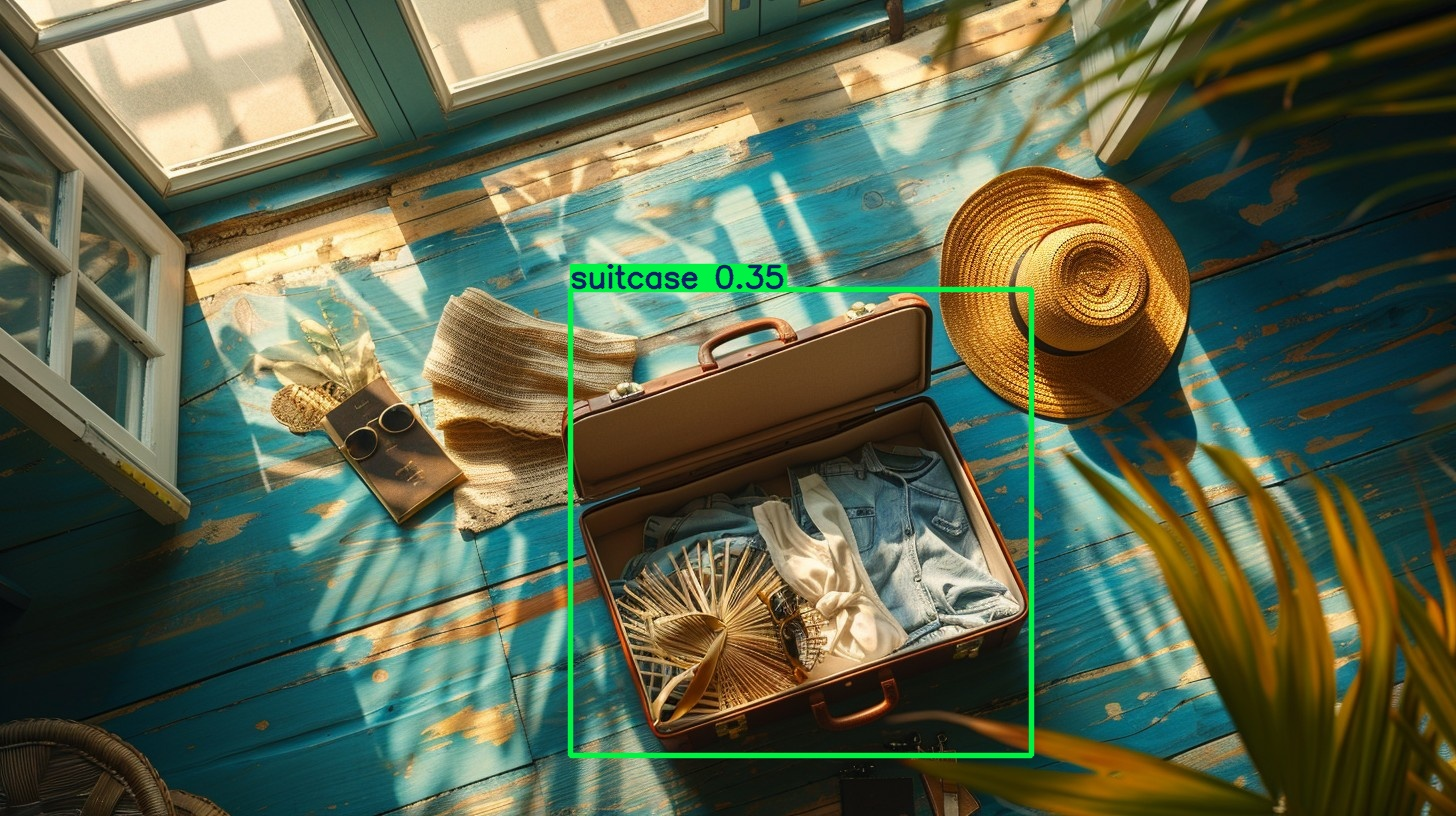

In [ ]:
from IPython.display import Image

Image('/content/runs/detect/predict/25.jpg')

# 2. Val
Validate a model's accuracy on the [COCO](https://docs.ultralytics.com/datasets/detect/coco/) dataset's `val` or `test` splits. The latest YOLOv8 [models](https://github.com/ultralytics/ultralytics#models) are downloaded automatically the first time they are used. See [YOLOv8 Val Docs](https://docs.ultralytics.com/modes/val/) for more information.

#Dataset

In [ ]:
# Download COCO val
import torch
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')  # download (780M - 5000 images)
!unzip -q tmp.zip -d datasets && rm tmp.zip  # unzip

100%|██████████| 780M/780M [00:04<00:00, 195MB/s]


In [ ]:
# Validate YOLOv8n on COCO8 val
!yolo val model=yolov8n.pt data=coco.yaml

Ultralytics YOLOv8.2.31 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
val: Scanning /content/datasets/coco/labels/val2017... 4952 images, 48 backgrounds, 0 corrupt: 100% 5000/5000 [00:02<00:00, 1984.35it/s]
val: New cache created: /content/datasets/coco/labels/val2017.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 313/313 [01:17<00:00,  4.04it/s]
                   all       5000      36335      0.634      0.474      0.521      0.371
                person       2693      10777      0.755      0.671      0.745      0.514
               bicycle        149        314       0.69      0.392      0.457      0.265
                   car        535       1918      0.648      0.514      0.562      0.364
            motorcycle        159        367      0.715       0.58      0.657      0.414
              airplane         97        143      0.81

# 3. Train

<p align=""><a href="https://bit.ly/ultralytics_hub"><img width="1000" src="https://github.com/ultralytics/assets/raw/main/yolov8/banner-integrations.png"/></a></p>

Train YOLOv8 on [Detect](https://docs.ultralytics.com/tasks/detect/), [Segment](https://docs.ultralytics.com/tasks/segment/), [Classify](https://docs.ultralytics.com/tasks/classify/) and [Pose](https://docs.ultralytics.com/tasks/pose/) datasets. See [YOLOv8 Train Docs](https://docs.ultralytics.com/modes/train/) for more information.

In [ ]:
#@title Select YOLOv8 🚀 logger {run: 'auto'}
logger = 'Comet' #@param ['Comet', 'TensorBoard']

if logger == 'Comet':
  %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir .

In [ ]:
# Train YOLOv8n on COCO8 for 3 epochs
!yolo train model=yolov8n.pt data={dataset.location}/data.yaml epochs=3 imgsz=416

Ultralytics YOLOv8.2.31 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/traffic-sign-detection-gtsrb-15/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

In [ ]:
!yolo predict model=yolov8n.yaml source='/content/sample.png'

Ultralytics YOLOv8.2.31 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/sample.png: 640x640 2 cars, 2 traffic lights, 11.2ms
Speed: 6.1ms preprocess, 11.2ms inference, 724.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


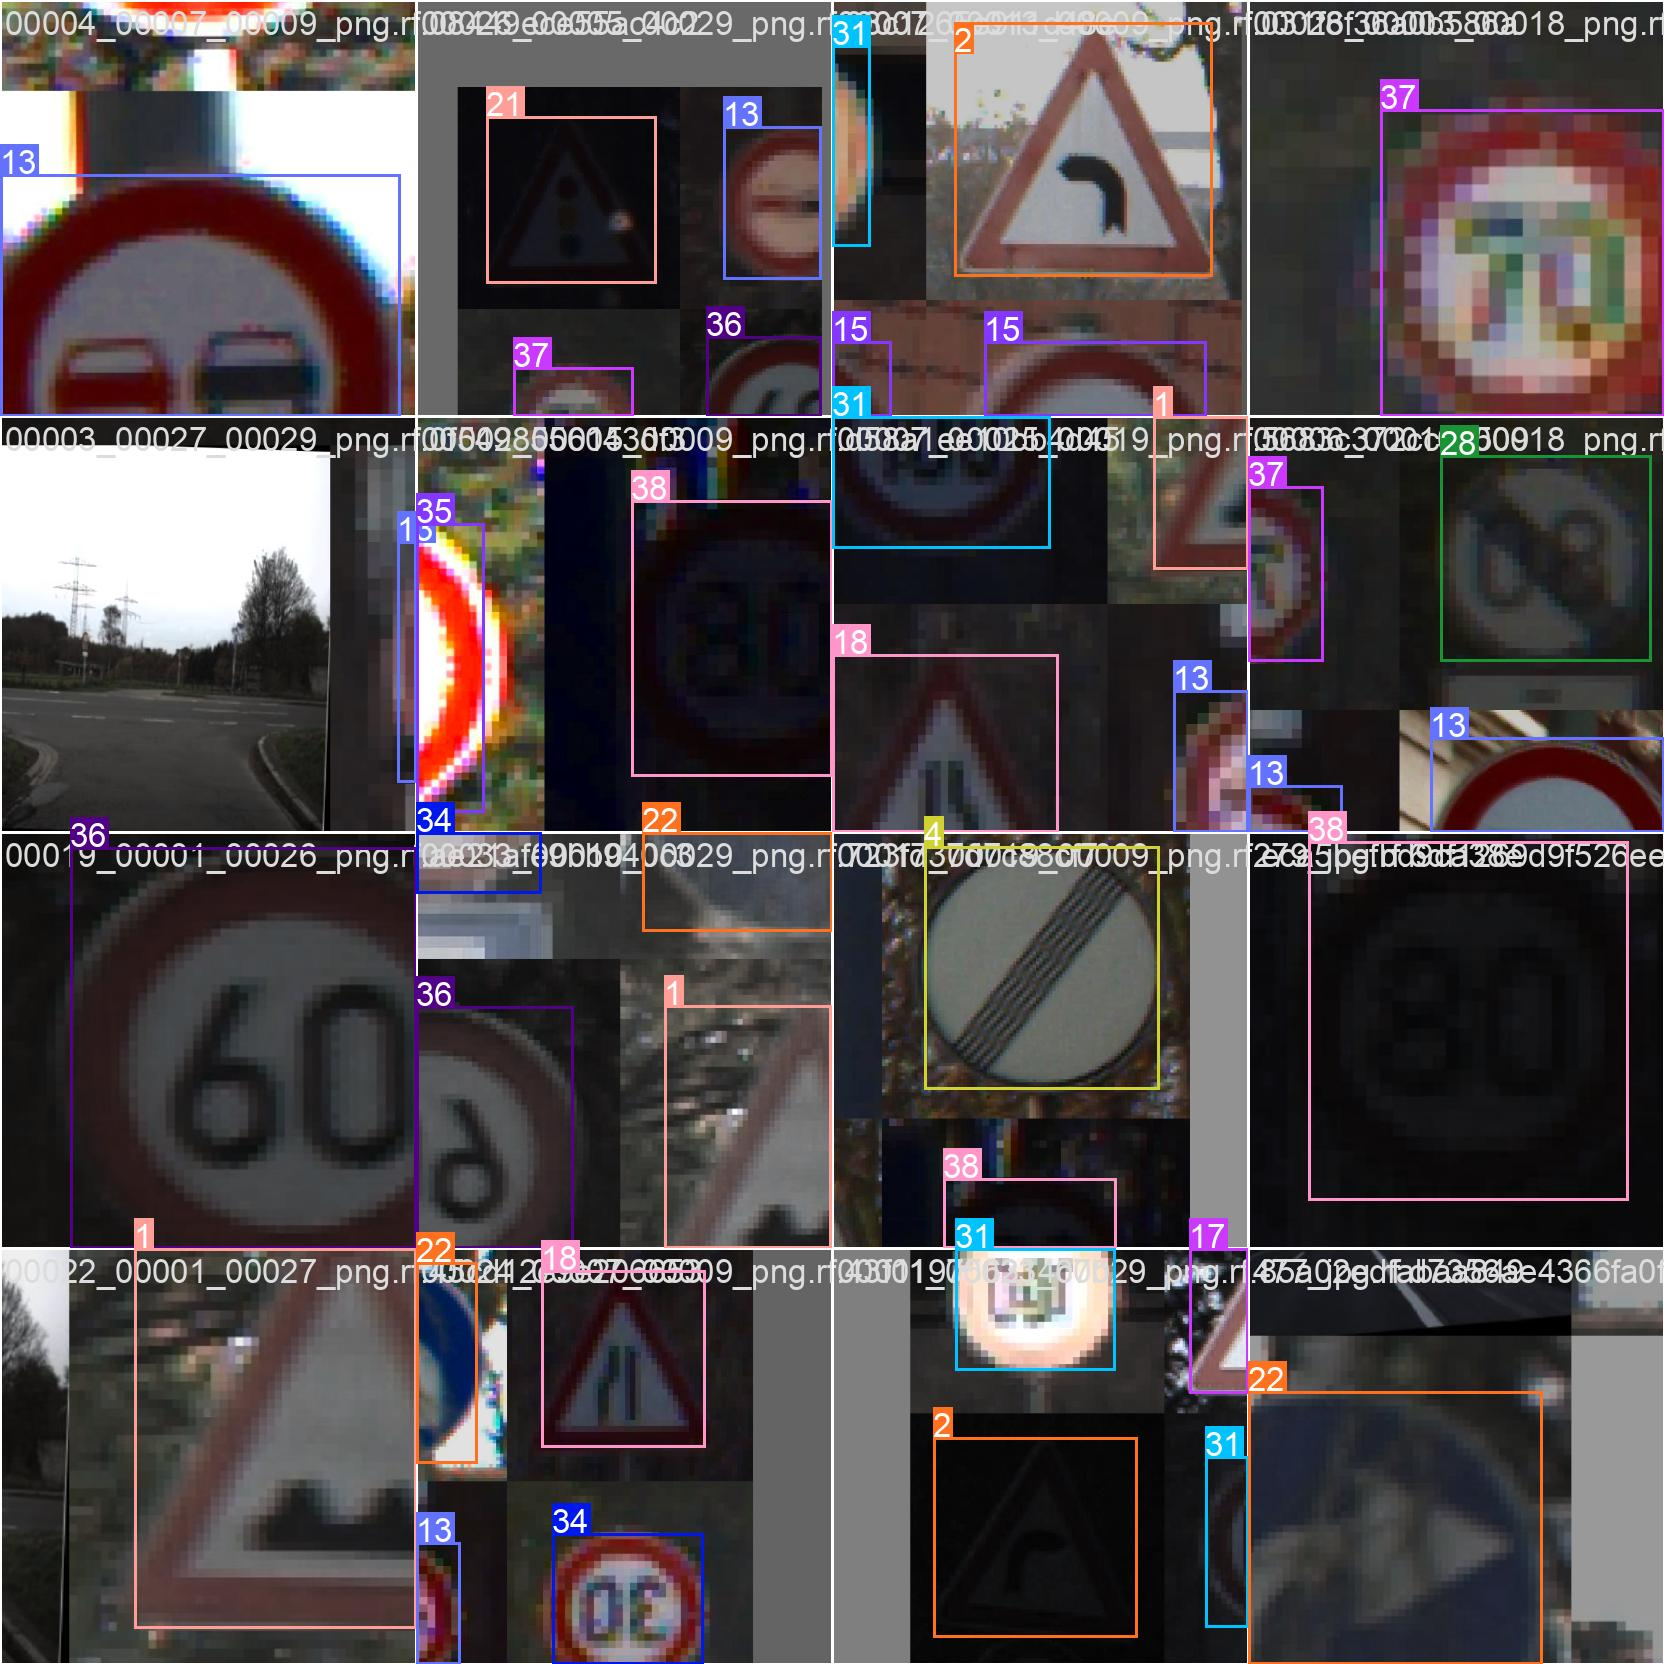

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/runs/detect/train6/train_batch2.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# 4. Export

Export a YOLOv8 model to any supported format below with the `format` argument, i.e. `format=onnx`. See [YOLOv8 Export Docs](https://docs.ultralytics.com/modes/export/) for more information.

- 💡 ProTip: Export to [ONNX](https://docs.ultralytics.com/integrations/onnx/) or [OpenVINO](https://docs.ultralytics.com/integrations/openvino/) for up to 3x CPU speedup.  
- 💡 ProTip: Export to [TensorRT](https://docs.ultralytics.com/integrations/tensorrt/) for up to 5x GPU speedup.

| Format                                                                   | `format` Argument | Model                     | Metadata | Arguments                                                            |
|--------------------------------------------------------------------------|-------------------|---------------------------|----------|----------------------------------------------------------------------|
| [PyTorch](https://pytorch.org/)                                          | -                 | `yolov8n.pt`              | ✅        | -                                                                    |
| [TorchScript](https://docs.ultralytics.com/integrations/torchscript)     | `torchscript`     | `yolov8n.torchscript`     | ✅        | `imgsz`, `optimize`, `batch`                                         |
| [ONNX](https://docs.ultralytics.com/integrations/onnx)                   | `onnx`            | `yolov8n.onnx`            | ✅        | `imgsz`, `half`, `dynamic`, `simplify`, `opset`, `batch`             |
| [OpenVINO](https://docs.ultralytics.com/integrations/openvino)           | `openvino`        | `yolov8n_openvino_model/` | ✅        | `imgsz`, `half`, `int8`, `batch`                                     |
| [TensorRT](https://docs.ultralytics.com/integrations/tensorrt)           | `engine`          | `yolov8n.engine`          | ✅        | `imgsz`, `half`, `dynamic`, `simplify`, `workspace`, `int8`, `batch` |
| [CoreML](https://docs.ultralytics.com/integrations/coreml)               | `coreml`          | `yolov8n.mlpackage`       | ✅        | `imgsz`, `half`, `int8`, `nms`, `batch`                              |
| [TF SavedModel](https://docs.ultralytics.com/integrations/tf-savedmodel) | `saved_model`     | `yolov8n_saved_model/`    | ✅        | `imgsz`, `keras`, `int8`, `batch`                                    |
| [TF GraphDef](https://docs.ultralytics.com/integrations/tf-graphdef)     | `pb`              | `yolov8n.pb`              | ❌        | `imgsz`, `batch`                                                     |
| [TF Lite](https://docs.ultralytics.com/integrations/tflite)              | `tflite`          | `yolov8n.tflite`          | ✅        | `imgsz`, `half`, `int8`, `batch`                                     |
| [TF Edge TPU](https://docs.ultralytics.com/integrations/edge-tpu)        | `edgetpu`         | `yolov8n_edgetpu.tflite`  | ✅        | `imgsz`, `batch`                                                     |
| [TF.js](https://docs.ultralytics.com/integrations/tfjs)                  | `tfjs`            | `yolov8n_web_model/`      | ✅        | `imgsz`, `half`, `int8`, `batch`                                     |
| [PaddlePaddle](https://docs.ultralytics.com/integrations/paddlepaddle)   | `paddle`          | `yolov8n_paddle_model/`   | ✅        | `imgsz`, `batch`                                                     |
| [NCNN](https://docs.ultralytics.com/integrations/ncnn)                   | `ncnn`            | `yolov8n_ncnn_model/`     | ✅        | `imgsz`, `half`, `batch`                                             |

In [ ]:
!yolo export model=yolov8n.pt format=torchscript

Ultralytics YOLOv8.2.3 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

TorchScript: starting export with torch 2.2.1+cu121...
TorchScript: export success ✅ 2.0s, saved as 'yolov8n.torchscript' (12.4 MB)

Export complete (4.0s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8n.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolov8n.torchscript imgsz=640 data=coco.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export


# 5. Python Usage

YOLOv8 was reimagined using Python-first principles for the most seamless Python YOLO experience yet. YOLOv8 models can be loaded from a trained checkpoint or created from scratch. Then methods are used to train, val, predict, and export the model. See detailed Python usage examples in the [YOLOv8 Python Docs](https://docs.ultralytics.com/usage/python/).

In [ ]:
from ultralytics import YOLO

# Load a model
#model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='/content/datasets/traffic-sign-detection-gtsrb-15/data.yaml', epochs=3, imgsz = 416)  # train the model
results = model.val()  # evaluate model performance on the validation set
results = model('/content/sample.png')  # predict on an image

#results = model.export(format='onnx')  # export the model to ONNX format

Ultralytics YOLOv8.2.31 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/traffic-sign-detection-gtsrb-15/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

train: Scanning /content/datasets/traffic-sign-detection-gtsrb-15/train/labels.cache... 3518 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3518/3518 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/traffic-sign-detection-gtsrb-15/valid/labels.cache... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000217, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.235      4.455      1.489         49        416:   9%|▉         | 20/220 [02:05<20:54,  6.27s/it]


KeyboardInterrupt: 